# Thông tin sinh viên

Bài tập 3

Tên sinh viên: Nguyễn Phương Tùng

MSSV: 21520524

Logistic Regression:


*   Khi không dùng sobel: 0.6333333333333333
*   Khi có dùng: 0.6333333333333333

(khác biệt ở tham số n_components)

KNN:

*   Khi không dùng sobel (k = 1): 0.6
*   Khi có dùng sobel (k = 1): 0.66666666666





# Import thư viện

In [1]:
from google.colab import drive
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Hàm của thầy: sobel_filters và calFeatureVector (2)

In [2]:
# Hàm Sobel filters
def sobel_filters(img):
    Sx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
    Sy = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)

    Ix = cv2.filter2D(img, -1, Sx)
    Iy = cv2.filter2D(img, -1, Sy)

    G = np.hypot(Ix, Iy)
    G = G / G.max() * 255
    theta = np.arctan2(Iy, Ix)

    return Ix, Iy, G, theta

In [3]:
# Hàm tính toán vector đặc trưng
def calFeatureVector(img):
    img_ = cv2.resize(img, (256, 256))
    _, _, G, _ = sobel_filters(img_)
    row_sum = np.sum(G, axis=1, dtype=np.float64).flatten()
    col_sum = np.sum(G, axis=0, dtype=np.float64).flatten()
    return np.hstack((row_sum, col_sum))

# Load dữ liệu

In [4]:
# Kết nối Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Đường dẫn đến thư mục chứa dữ liệu trong Google Drive
data_path = '/content/drive/My Drive/CS231.O22.1/Baitap/Baitap3/Dataset/dogscats_small'

In [6]:
# Liệt kê các thư mục train và test
train_dir = os.path.join(data_path, 'train')
test_dir = os.path.join(data_path, 'test')

# Kiểm tra lại dữ liệu đã load đúng hay chưa?

In [7]:
# Kiểm tra xem các thư mục đã tồn tại chưa
print("Files in train directory:")
print(os.listdir(train_dir))

Files in train directory:
['dog.0.jpg', 'dog.10.jpg', 'dog.1.jpg', 'dog.11.jpg', 'dog.12.jpg', 'dog.13.jpg', 'dog.14.jpg', 'dog.15.jpg', 'dog.16.jpg', 'dog.17.jpg', 'dog.18.jpg', 'dog.19.jpg', 'dog.20.jpg', 'dog.2.jpg', 'dog.21.jpg', 'dog.22.jpg', 'dog.23.jpg', 'dog.24.jpg', 'dog.25.jpg', 'dog.26.jpg', 'dog.27.jpg', 'dog.28.jpg', 'dog.29.jpg', 'dog.3.jpg', 'dog.4.jpg', 'dog.5.jpg', 'dog.6.jpg', 'dog.7.jpg', 'dog.8.jpg', 'dog.9.jpg', 'cat.0.jpg', 'cat.1.jpg', 'cat.10.jpg', 'cat.11.jpg', 'cat.12.jpg', 'cat.13.jpg', 'cat.14.jpg', 'cat.15.jpg', 'cat.16.jpg', 'cat.17.jpg', 'cat.18.jpg', 'cat.19.jpg', 'cat.20.jpg', 'cat.2.jpg', 'cat.21.jpg', 'cat.22.jpg', 'cat.23.jpg', 'cat.24.jpg', 'cat.25.jpg', 'cat.26.jpg', 'cat.27.jpg', 'cat.28.jpg', 'cat.29.jpg', 'cat.3.jpg', 'cat.4.jpg', 'cat.5.jpg', 'cat.6.jpg', 'cat.7.jpg', 'cat.8.jpg', 'cat.9.jpg']


In [8]:
print("Files in test directory:")
print(os.listdir(test_dir))

Files in test directory:
['dog.23.jpg', 'dog.26.jpg', 'dog.25.jpg', 'dog.27.jpg', 'dog.21.jpg', 'dog.24.jpg', 'cat.28.jpg', 'dog.30.jpg', 'cat.29.jpg', 'cat.22.jpg', 'cat.5.jpg', 'cat.20.jpg', 'cat.19.jpg', 'cat.15.jpg', 'cat.16.jpg', 'dog.1.jpg', 'cat.13.jpg', 'cat.14.jpg', 'cat.10.jpg', 'cat.11.jpg', 'cat.7.jpg', 'cat.8.jpg', 'cat.6.jpg', 'cat.9.jpg', 'dog.2.jpg', 'dog.3.jpg', 'dog.4.jpg', 'dog.12.jpg', 'dog.17.jpg', 'dog.18.jpg']


## Hàm load đầu tiên để check hình ảnh và label của nó

In [9]:
# Hàm để tải dữ liệu và gán nhãn
def load_data_from_directory_and_check(directory):
    X = []
    y = []
    class_labels = {'cat': 0, 'dog': 1}

    for filename in os.listdir(directory):
        # Đọc hình ảnh
        img_path = os.path.join(directory, filename)
        img = cv2.imread(img_path)
        img = cv2.resize(img, (256, 256))  # Resize ảnh về kích thước cố định
        img = img.astype('float32') / 255.0  # Chuẩn hóa ảnh

        # Gán nhãn dựa trên tên file
        if filename.startswith('cat'):
            label = class_labels['cat']
        #elif filename.startswith('tamgiac'):
        #    label = class_labels['tamgiac']
        elif filename.startswith('dog'):
            label = class_labels['dog']
        else:
            continue

        X.append(img)
        y.append(label)

    return np.array(X), np.array(y)

In [10]:
# Tải dữ liệu train
X_train, y_train = load_data_from_directory_and_check(train_dir)

# Tải dữ liệu test
X_test, y_test = load_data_from_directory_and_check(test_dir)

In [11]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (60, 256, 256, 3)
y_train shape: (60,)
X_test shape: (30, 256, 256, 3)
y_test shape: (30,)


Training images:


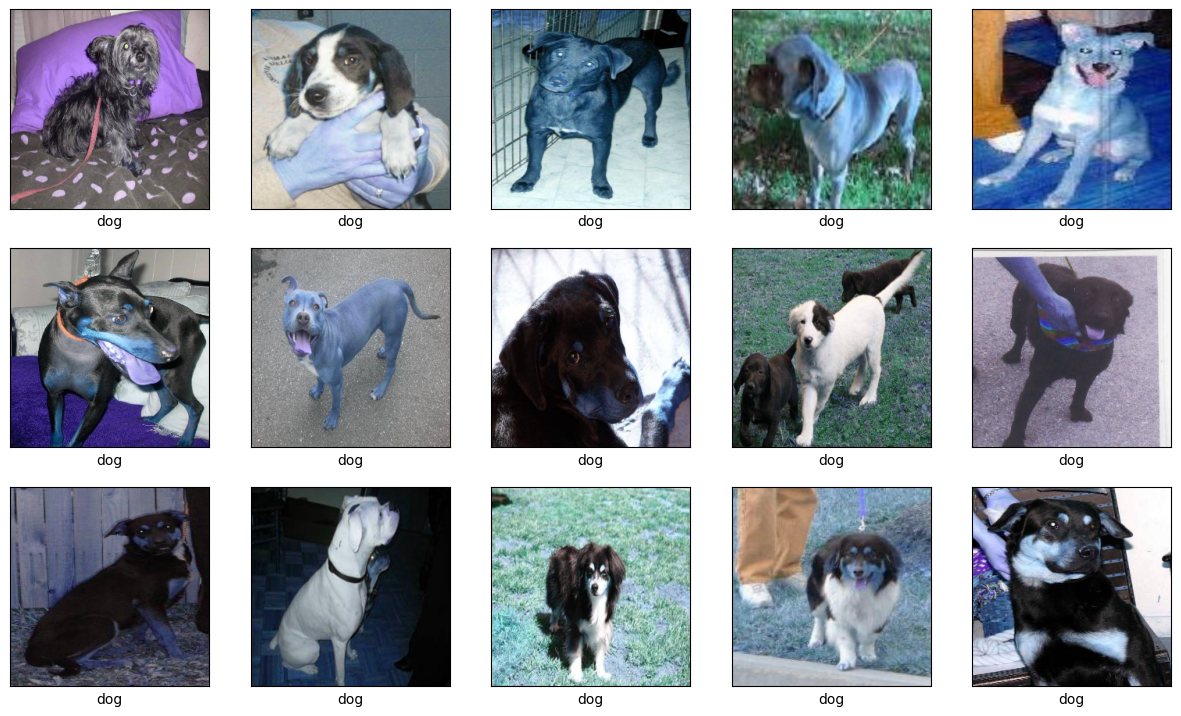

Testing images:


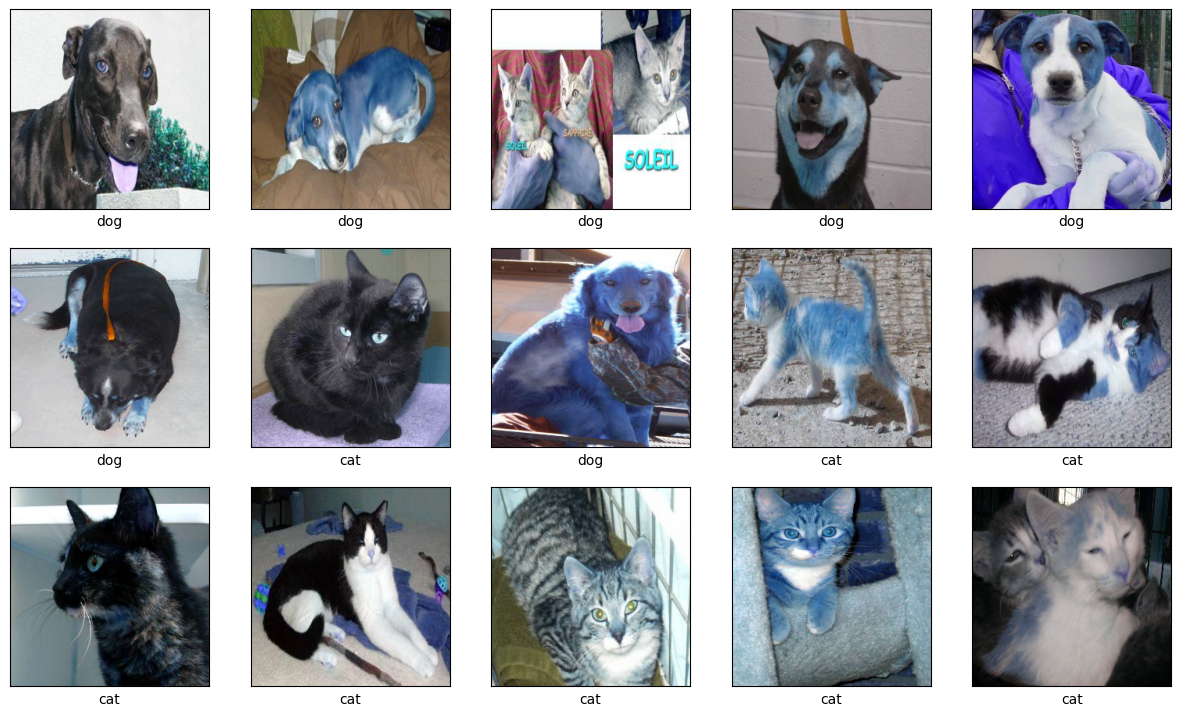

In [12]:
# Hàm để hiển thị hình ảnh cùng với nhãn
def plot_images_with_labels(images, labels, class_names, num_images=10):
    plt.figure(figsize=(15, 15))
    for i in range(min(num_images, len(images))):
        plt.subplot(5, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i])
        plt.xlabel(class_names[labels[i]])
    plt.show()

# Class labels
class_names = ['cat', 'dog']

# Hiển thị một số hình ảnh từ tập train cùng với nhãn
print("Training images:")
plot_images_with_labels(X_train, y_train, class_names, num_images=15)

# Hiển thị một số hình ảnh từ tập test cùng với nhãn
print("Testing images:")
plot_images_with_labels(X_test, y_test, class_names, num_images=15)

**Nhận xét:** 100% biển báo được gán đúng với nhãn tương ứng của nó (trong cả tập train và test).

# Model: Logistic Regression

## Khi không dùng sobel

In [31]:
import os
import cv2
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

# Hàm để tải dữ liệu và gán nhãn
def load_data_from_directory_and_check(directory):
    X = []
    y = []
    class_labels = {'cat': 0, 'dog': 1}

    for filename in os.listdir(directory):
        # Đọc hình ảnh
        img_path = os.path.join(directory, filename)
        img = cv2.imread(img_path)
        img = cv2.resize(img, (256, 256))  # Resize ảnh về kích thước cố định
        img = img.astype('float32') / 255.0  # Chuẩn hóa ảnh

        # Gán nhãn dựa trên tên file
        if filename.startswith('cat'):
            label = class_labels['cat']
        elif filename.startswith('dog'):
            label = class_labels['dog']
        else:
            continue

        # Tính toán vector đặc trưng
        #feature_vector = calFeatureVector(img)
        #X.append(feature_vector)
        X.append(img)
        y.append(label)

    return np.array(X), np.array(y)

# Hàm Sobel filters và trích xuất đặc trưng
def sobel_filters(img):
    Sx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
    Sy = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)

    Ix = cv2.filter2D(img, -1, Sx)
    Iy = cv2.filter2D(img, -1, Sy)

    G = np.hypot(Ix, Iy)
    G = G / G.max() * 255
    theta = np.arctan2(Iy, Ix)

    return Ix, Iy, G, theta

def calFeatureVector(img):
    img_ = cv2.resize(img, (256, 256))
    _, _, G, _ = sobel_filters(img_)
    row_sum = np.sum(G, axis=1, dtype=np.float64)
    col_sum = np.sum(G, axis=0, dtype=np.float64)
    return np.hstack((row_sum, col_sum))


# Tải dữ liệu train
X_train, y_train = load_data_from_directory_and_check(train_dir)

# Tải dữ liệu test
X_test, y_test = load_data_from_directory_and_check(test_dir)

# Kiểm tra kích thước của dữ liệu
print("Train data shape:", X_train.shape)
print("Test data shape:", X_test.shape)

# Reshape dữ liệu để phù hợp với Logistic Regression
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_train_flat = scaler.fit_transform(X_train_flat)
X_test_flat = scaler.transform(X_test_flat)

# Áp dụng PCA để giảm chiều dữ liệu
pca = PCA(n_components=0.95)  # Giữ lại 95% phương sai
X_train_pca = pca.fit_transform(X_train_flat)
X_test_pca = pca.transform(X_test_flat)

# Khởi tạo và huấn luyện mô hình phân loại với Grid Search để tìm siêu tham số tốt nhất
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
log_reg = LogisticRegression(max_iter=1000, random_state=42)
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_pca, y_train)

# Lấy mô hình tốt nhất
best_log_reg = grid_search.best_estimator_

# Dự đoán trên tập kiểm tra
y_pred = best_log_reg.predict(X_test_pca)

# Đánh giá mô hình
print("Best Parameters:", grid_search.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=['cat', 'dog']))


Train data shape: (60, 256, 256, 3)
Test data shape: (30, 256, 256, 3)
Best Parameters: {'C': 0.1}
Accuracy: 0.6333333333333333
Classification Report:
               precision    recall  f1-score   support

         cat       0.63      0.75      0.69        16
         dog       0.64      0.50      0.56        14

    accuracy                           0.63        30
   macro avg       0.63      0.62      0.62        30
weighted avg       0.63      0.63      0.63        30



## Khi có dùng sobel

In [33]:
import os
import cv2
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

# Hàm để tải dữ liệu và gán nhãn
def load_data_from_directory_and_check(directory):
    X = []
    y = []
    class_labels = {'cat': 0, 'dog': 1}

    for filename in os.listdir(directory):
        # Đọc hình ảnh
        img_path = os.path.join(directory, filename)
        img = cv2.imread(img_path)
        img = cv2.resize(img, (256, 256))  # Resize ảnh về kích thước cố định
        img = img.astype('float32') / 255.0  # Chuẩn hóa ảnh

        # Gán nhãn dựa trên tên file
        if filename.startswith('cat'):
            label = class_labels['cat']
        elif filename.startswith('dog'):
            label = class_labels['dog']
        else:
            continue

        # Tính toán vector đặc trưng
        feature_vector = calFeatureVector(img)
        X.append(feature_vector)
        #X.append(img)
        y.append(label)

    return np.array(X), np.array(y)

# Hàm Sobel filters và trích xuất đặc trưng
def sobel_filters(img):
    Sx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
    Sy = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)

    Ix = cv2.filter2D(img, -1, Sx)
    Iy = cv2.filter2D(img, -1, Sy)

    G = np.hypot(Ix, Iy)
    G = G / G.max() * 255
    theta = np.arctan2(Iy, Ix)

    return Ix, Iy, G, theta

def calFeatureVector(img):
    img_ = cv2.resize(img, (256, 256))
    _, _, G, _ = sobel_filters(img_)
    row_sum = np.sum(G, axis=1, dtype=np.float64)
    col_sum = np.sum(G, axis=0, dtype=np.float64)
    return np.hstack((row_sum, col_sum))


# Tải dữ liệu train
X_train, y_train = load_data_from_directory_and_check(train_dir)

# Tải dữ liệu test
X_test, y_test = load_data_from_directory_and_check(test_dir)

# Kiểm tra kích thước của dữ liệu
print("Train data shape:", X_train.shape)
print("Test data shape:", X_test.shape)

# Reshape dữ liệu để phù hợp với Logistic Regression
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_train_flat = scaler.fit_transform(X_train_flat)
X_test_flat = scaler.transform(X_test_flat)

# Áp dụng PCA để giảm chiều dữ liệu
pca = PCA(n_components=40)  # Giữ lại 95% phương sai
X_train_pca = pca.fit_transform(X_train_flat)
X_test_pca = pca.transform(X_test_flat)

# Khởi tạo và huấn luyện mô hình phân loại với Grid Search để tìm siêu tham số tốt nhất
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
log_reg = LogisticRegression(max_iter=1000, random_state=42)
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_pca, y_train)

# Lấy mô hình tốt nhất
best_log_reg = grid_search.best_estimator_

# Dự đoán trên tập kiểm tra
y_pred = best_log_reg.predict(X_test_pca)

# Đánh giá mô hình
print("Best Parameters:", grid_search.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=['cat', 'dog']))

Train data shape: (60, 256, 6)
Test data shape: (30, 256, 6)
Best Parameters: {'C': 1}
Accuracy: 0.6333333333333333
Classification Report:
               precision    recall  f1-score   support

         cat       0.65      0.69      0.67        16
         dog       0.62      0.57      0.59        14

    accuracy                           0.63        30
   macro avg       0.63      0.63      0.63        30
weighted avg       0.63      0.63      0.63        30



# Model: KNN

## Khi không dùng sobel

In [27]:
import os
import cv2
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

# Hàm để tải dữ liệu và gán nhãn
def load_data_from_directory(directory):
    X = []
    y = []
    class_labels = {'cat': 0, 'dog': 1}

    for filename in os.listdir(directory):
        # Đọc hình ảnh
        img_path = os.path.join(directory, filename)
        img = cv2.imread(img_path)
        img = cv2.resize(img, (256, 256))  # Resize ảnh về kích thước cố định
        img = img.astype('float32') / 255.0  # Chuẩn hóa ảnh

        # Gán nhãn dựa trên tên file
        if filename.startswith('cat'):
            label = class_labels['cat']
        elif filename.startswith('dog'):
            label = class_labels['dog']
        else:
            continue

        # Tính toán vector đặc trưng
        #feature_vector = calFeatureVector(img)
        #X.append(feature_vector)
        X.append(img)
        y.append(label)

    return np.array(X), np.array(y)

# Hàm Sobel filters và trích xuất đặc trưng
def sobel_filters(img):
    Sx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
    Sy = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)

    Ix = cv2.filter2D(img, -1, Sx)
    Iy = cv2.filter2D(img, -1, Sy)

    G = np.hypot(Ix, Iy)
    G = G / G.max() * 255
    theta = np.arctan2(Iy, Ix)

    return Ix, Iy, G, theta

def calFeatureVector(img):
    img_ = cv2.resize(img, (256, 256))
    _, _, G, _ = sobel_filters(img_)
    row_sum = np.sum(G, axis=1, dtype=np.float64)
    col_sum = np.sum(G, axis=0, dtype=np.float64)
    return np.hstack((row_sum, col_sum))


X_train, y_train = load_data_from_directory(train_dir)
X_test, y_test = load_data_from_directory(test_dir)

# Kiểm tra kích thước của dữ liệu
print("Train data shape:", X_train.shape)
print("Test data shape:", X_test.shape)

# Reshape dữ liệu để phù hợp với KNeighborsClassifier
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_train_flat = scaler.fit_transform(X_train_flat)
X_test_flat = scaler.transform(X_test_flat)

# Áp dụng PCA để giảm chiều dữ liệu
pca = PCA(n_components=40)  # Giữ lại 95% phương sai
X_train_pca = pca.fit_transform(X_train_flat)
X_test_pca = pca.transform(X_test_flat)

# Khởi tạo và huấn luyện mô hình phân loại với Grid Search để tìm siêu tham số tốt nhất
param_grid = {'n_neighbors': [1, 3, 5, 7, 9, 11, 13], 'weights': ['uniform', 'distance']}
knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_pca, y_train)

# Lấy mô hình tốt nhất
best_knn = grid_search.best_estimator_

# Dự đoán trên tập kiểm tra
y_pred = best_knn.predict(X_test_pca)

# Đánh giá mô hình
print("Best Parameters:", grid_search.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=['cat', 'dog']))


Train data shape: (60, 256, 256, 3)
Test data shape: (30, 256, 256, 3)
Best Parameters: {'n_neighbors': 1, 'weights': 'uniform'}
Accuracy: 0.6
Classification Report:
               precision    recall  f1-score   support

         cat       0.64      0.56      0.60        16
         dog       0.56      0.64      0.60        14

    accuracy                           0.60        30
   macro avg       0.60      0.60      0.60        30
weighted avg       0.61      0.60      0.60        30



## Khi có dùng sobel

In [24]:
import os
import cv2
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

# Hàm để tải dữ liệu và gán nhãn
def load_data_from_directory(directory):
    X = []
    y = []
    class_labels = {'cat': 0, 'dog': 1}

    for filename in os.listdir(directory):
        # Đọc hình ảnh
        img_path = os.path.join(directory, filename)
        img = cv2.imread(img_path)
        img = cv2.resize(img, (256, 256))  # Resize ảnh về kích thước cố định
        img = img.astype('float32') / 255.0  # Chuẩn hóa ảnh

        # Gán nhãn dựa trên tên file
        if filename.startswith('cat'):
            label = class_labels['cat']
        elif filename.startswith('dog'):
            label = class_labels['dog']
        else:
            continue

        # Tính toán vector đặc trưng
        feature_vector = calFeatureVector(img)
        X.append(feature_vector)
        y.append(label)

    return np.array(X), np.array(y)

# Hàm Sobel filters và trích xuất đặc trưng
def sobel_filters(img):
    Sx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
    Sy = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)

    Ix = cv2.filter2D(img, -1, Sx)
    Iy = cv2.filter2D(img, -1, Sy)

    G = np.hypot(Ix, Iy)
    G = G / G.max() * 255
    theta = np.arctan2(Iy, Ix)

    return Ix, Iy, G, theta

def calFeatureVector(img):
    img_ = cv2.resize(img, (256, 256))
    _, _, G, _ = sobel_filters(img_)
    row_sum = np.sum(G, axis=1, dtype=np.float64)
    col_sum = np.sum(G, axis=0, dtype=np.float64)
    return np.hstack((row_sum, col_sum))


X_train, y_train = load_data_from_directory(train_dir)
X_test, y_test = load_data_from_directory(test_dir)

# Kiểm tra kích thước của dữ liệu
print("Train data shape:", X_train.shape)
print("Test data shape:", X_test.shape)

# Reshape dữ liệu để phù hợp với KNeighborsClassifier
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_train_flat = scaler.fit_transform(X_train_flat)
X_test_flat = scaler.transform(X_test_flat)

# Áp dụng PCA để giảm chiều dữ liệu
pca = PCA(n_components=40)  # Giữ lại 95% phương sai
X_train_pca = pca.fit_transform(X_train_flat)
X_test_pca = pca.transform(X_test_flat)

# Khởi tạo và huấn luyện mô hình phân loại với Grid Search để tìm siêu tham số tốt nhất
param_grid = {'n_neighbors': [1, 3, 5, 7, 9, 11, 13], 'weights': ['uniform', 'distance']}
knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_pca, y_train)

# Lấy mô hình tốt nhất
best_knn = grid_search.best_estimator_

# Dự đoán trên tập kiểm tra
y_pred = best_knn.predict(X_test_pca)

# Đánh giá mô hình
print("Best Parameters:", grid_search.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=['cat', 'dog']))


Train data shape: (60, 256, 6)
Test data shape: (30, 256, 6)
Best Parameters: {'n_neighbors': 1, 'weights': 'uniform'}
Accuracy: 0.6666666666666666
Classification Report:
               precision    recall  f1-score   support

         cat       0.71      0.62      0.67        16
         dog       0.62      0.71      0.67        14

    accuracy                           0.67        30
   macro avg       0.67      0.67      0.67        30
weighted avg       0.67      0.67      0.67        30



**Nhận xét:** Model Logistic Regression đạt được độ chính xác cao nhất khi không dùng sobel là 0.6333333333333333. Còn KNN đạt được độ chinh xác cao nhất khi có dùng sobel là 0.6666666666666666.

Và ngược lại, model Logistic Regression đạt được độ chính xác cao nhất khi có dùng sobel là 0.6333333333333333. KNN đạt được độ chinh xác cao nhất khi không dùng sobel là 0.6.

KNN đạt được độ chính xác cao nhất là 0.66666666666. Còn Logistic Regression có độ chính xác cao nhất là 0.66663333. Như vậy, có thể nói KNN tốt hơn Logistic Regression một chút.